In [25]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [26]:
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

### load inputs

In [132]:
xvalO = np.load("savedOutputs/xvalO.npy")
yvalO = np.load("savedOutputs/yvalO.npy")
xerrO = np.load("savedOutputs/xerrO.npy")
xlowO = np.load("savedOutputs/xlowO.npy")
xval = np.load("savedOutputs/xval.npy")
yval = np.load("savedOutputs/yval.npy")
xerr = np.load("savedOutputs/xerr.npy")

toyList = np.load("savedOutputs/toyList.npy")
lumiToyDict = np.load("savedOutputs/lumiToyList.npy")
meanGPnom = np.load("savedOutputs/initialGPfit.npy")
fixedHyperparams = np.load("savedOutputs/fixedHyperparams.npy")
sigToys = np.load("savedOutputs/signalToys.npy")
sigToysO = np.load("savedOutputs/signalToysO.npy")

standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]

### Gaussian signal function

In [28]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

### 3 and 5 parameters fit function

In [29]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  
def model_5param(t, params, xErr=xerr): 
    p0, p1, p2, p3, p4 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*(xErr)

### Calculate z values and chi squared 

In [30]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

### Poisson log likelihood

In [107]:
#same gaussian apprx as george (just no constraint) obs-pred/sqrt(obs) gaus. (obs-sig-mean GP)/sqrt(obs) for poisson
#meaured, expected (lambda)
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.) 
        return lnpoisson
    


In [120]:
def simpleLogPoisson_nogamma(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par 
        return lnpoisson
    

def logLike_gpLikeFF_nogamma(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson_nogamma(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff_nogamma:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson_nogamma(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_3ff_sig_nogamma:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson_nogamma(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff_nogamma:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += -simpleLogPoisson_nogamma(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig_nogamma:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson_nogamma(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

In [109]:
def simpleGaussian(d, b):
    if d < 0: 
        return np.inf
    elif d == 0: return 0
    else:
        lnGaus = 0.5*((d-b)/np.sqrt(d))**2
        return lnGaus
    
def logLike_gpLikeFF_gaus(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += simpleGaussian(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff_gaus:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += simpleGaussian(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_3ff_sig_gaus:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += simpleGaussian(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff_gaus:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += simpleGaussian(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig_gaus:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += simpleGaussian(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf   
    


### Make toys: take 5 parameter fit to data and add Poisson noise

In [34]:
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys

### remove zero count bins to use for GP fits

In [35]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### fit for noncentrality parameter of non central chi-squared

In [36]:
def ncchi(x, nc):#, amp):
    return ss.ncx2.pdf(x, 1., nc) #amp*

### plot distribution of log likelihood from fits to toys

In [204]:
def makePrettyPlots_LLH(GP_LLH, FF_LLH, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)

    #lowx = 0
    #highx = 10
    lowx = min(min(GP_LLH), min(FF_LLH))
    highx = max(max(GP_LLH), max(FF_LLH))
    bins = np.linspace(lowx, highx, 200)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    
    hGP, _, _ = ax1.hist(GP_LLH, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    if drawchi2:
        bf_params, bf_cov = op.curve_fit(ncchi, bin_centers, hGP)
        print "nc ", bf_params
        nc_chi = sum(hGP)*dx*ss.ncx2.pdf(bin_centers, 1., bf_params[0]) #bf_params[1]*
        ax1.plot(bin_centers, nc_chi, c='r', linewidth=2)
    
    
    hFF, _, _ =ax2.hist(FF_LLH, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    if drawchi2:
        bf_params, bf_cov = op.curve_fit(ncchi, bin_centers, hFF)
        print "nc ", bf_params
        nc_chi = sum(hFF)*dx*ss.ncx2.pdf(bin_centers, 1., bf_params[0]) #bf_params[1]*
        ax2.plot(bin_centers, nc_chi, c='r', linewidth=3)

    plt.show()




### Poisson likelihood to use for Gaussian Process, for 3 parameter fit functions, 3 parameter fit function with signal strength parameter, 5 parameter fit function, and 5 parameter fit function with signal strength parameter. 

In [110]:
def logLike_gpLikeFF(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_3ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

### Minuit minimization of 3 parameter fit function, 3 parameter plus signal strength, 5 parameter, and 5 parameter plus signal strength. minimize negative log likelihood, return minimum negative log likelihood and fit parameters corresponding to minimum.

In [165]:
def fit_3ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 10:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  limit_p0 = (0, 20.), limit_p1 = (-20., 20.), limit_p2 = (-20., 20.))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 9: 
            print "retry number = ", 10, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0)
        numRetries+=1 

    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

def fit_3ff_sig(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 15:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 0.1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, N = init3,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 10.), limit_p1 = (-20., 20.), limit_p2 = (-20., 20.), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 14: 
            print "retry number = ", 15, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

def fit_5ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-20, 20), limit_p4 = (-20, 20))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

def fit_5ff_sig(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        init5 = np.random.random() * 1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4, N = init5,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-20, 20), limit_p4 = (-20, 20), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

### mean function for GP - 3 parameter fit function. negative log likelihood for Gaussian Process - from george. Minuit minimzation for GP negative log likelihood. Hyperparameters and mean function parameters are fixed, just fitting signal strength

In [40]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_tempSig_fixedH:
    def __init__(self, x, y, xerr, sigTemp):
        self.x = x
        self.y = y
        self.xerr = xerr
        self.sigTemp = sigTemp
    def __call__(self, N):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr)-N*self.sigTemp)
        except:
            return np.inf        
        
def fit_gp_tempSig_fixedH_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params




### fit Gaussian Process background only and background plus signal on toys with injected signal. Check Poisson likelihood as well as george Gaussian likelihood. Hyperparameters and mean function parameters are fixed

In [133]:
standardParamSets = [(1500,2000,250), (15, 6000,250)]

In [192]:
btime=time.time()
standardParamSets = [(1500,2000,250), (15, 6000,250)]

#listGP_N=[]
LLlistGP={}
LLlistGPP={}
LLlistGPG={}
LLlistGPng={}
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    LLlistGP[m]=[]
    LLlistGPP[m]=[]
    LLlistGPG[m]=[]
    LLlistGPng[m]=[]
    #listGP_toyN=[]
        
    for itoy, toy in enumerate(toyList):
        if not itoy%500: 
            #np.save("LLH_GP", LLlistGP_b)
            print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy + signalTemplate

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy + signalTemplateO

        #BACKGROUND ONLY FIT GP
        if not itoy%500:
            pgpb_stime = time.time()
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp1 = george.GP(kernel1)
        gp1.compute(xtoy, np.sqrt(ydata))
        meanGP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGP1 = meanGP1p+ model_3param(xvalO,(p0,p1,p2),xerrO)
        gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
        if not itoy%500:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime

        #BACKGROUND+SIGNAL FIT GP
        if not itoy%500:
            pgpsb_stime = time.time()
        lnProb = logLike_gp_tempSig_fixedH(xtoy,ydata, xtoyerr, signalTemplate)
        minimumLLH, best_fit_gp = fit_gp_tempSig_fixedH_minuit(lnProb, False)
        if np.isinf(minimumLLH): continue
        mu = best_fit_gp[0]
        #listGP_toyN.append(mu*n)
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate, xvalO)
        meanGP = meanGPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
        meanGPsig = meanGP+mu*signalTemplateO
        gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate)
        if not itoy%500:
            pgpsb_etime = time.time()
            print "background + signal time:", pgpsb_etime - pgpsb_stime
        
        #LLlistGP[m].append(-2*(gpLLH-gpLLHSig))
        #LLlistGPP[m].append(-2*(-logLike_gpLikeFF(ydataO, meanGP1)+logLike_gpLikeFF(ydataO, meanGPsig)))
        LLlistGPG[m].append(-2*(-logLike_gpLikeFF_gaus(ydataO, meanGP1)+logLike_gpLikeFF_gaus(ydataO, meanGPsig)))
        #LLlistGPng[m].append(-2*(-logLike_gpLikeFF_nogamma(ydataO, meanGP1)+logLike_gpLikeFF_nogamma(ydataO, meanGPsig)))

    #listGP_N.append([np.mean(np.array(listGP_toyN)),np.var(np.array(listGP_toyN)), np.std(np.array(listGP_toyN))])
etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"   

(1500, 2000, 250)
0
background only time: 0.00383400917053
background + signal time: 0.0534660816193
500
background only time: 0.00311207771301
background + signal time: 0.0275809764862
1000
background only time: 0.00292110443115
background + signal time: 0.0393660068512
1500
background only time: 0.00291705131531
background + signal time: 0.0275778770447
2000
background only time: 0.00290107727051
background + signal time: 0.0486478805542
2500
background only time: 0.00299501419067
background + signal time: 0.0508649349213
3000
background only time: 0.00282597541809
background + signal time: 0.0419619083405
3500
background only time: 0.00285077095032
background + signal time: 0.049910068512
4000
background only time: 0.00288105010986
background + signal time: 0.0480451583862
4500
background only time: 0.00285410881042
background + signal time: 0.0277218818665
5000
background only time: 0.00356793403625
background + signal time: 0.0540299415588
5500
background only time: 0.002794027328

### fit 3 parameter fit function with and without signal component on toys with injected signal. Fit all 3 background parameters and signal strength

In [171]:
btime=time.time()
standardParamSets = [(1500,2000,250), (15, 6000,250)]

listFF_N={}

LLlistFF={}
LLlistFFG={}
LLlistFFng={}

paramlistFF_b={}
paramlistFFG_b={}
paramlistFFng_b={}
paramlistFF_sb={}
paramlistFFG_sb={}
paramlistFFng_sb={}



for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    

    LLlistFF[m]=[]
    LLlistFFG[m]=[]
    LLlistFFng[m]=[]
    
    paramlistFF_b[m]=[]
    paramlistFFG_b[m]=[]
    paramlistFFng_b[m]=[]
    paramlistFF_sb[m]=[]
    paramlistFFG_sb[m]=[]
    paramlistFFng_sb[m]=[]
    
    #LLlistFF5_b[m]=[]
    listFF_N[m]=[]   



        
    for itoy, toy in enumerate(toyList[:1000]):
        if not itoy%500: 
            np.save("LLH_3Param_withSignal", LLlistFF)
            np.save("LLHG_3Param_withSignal", LLlistFFG)
            np.save("LLHng_3Param_withSignal", LLlistFFng)
            #np.save("LLH_5Param_withSignal", LLlistFF5_b)
            print itoy
        if not itoy%10: 
            print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        
        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy + signalTemplate

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy + signalTemplateO
        
        #######################################################
        if not itoy%500:
            p3b_stime = time.time()
        #BACKGROUND ONLY 3 PARAM FIT
        lnProb = logLike_3ff(xvalO, ydataO ,xerrO)
        ll_b3, best_fit_params = fit_3ff(lnProb, False)
        paramlistFF_b[m].append(best_fit_params)
        #######
        lnProbng = logLike_3ff_nogamma(xvalO, ydataO ,xerrO)
        ll_b3ng, best_fit_params = fit_3ff(lnProbng, False)
        paramlistFFng_b[m].append(best_fit_params)
        ####### 
        lnProbG = logLike_3ff_gaus(xvalO, ydataO ,xerrO)
        ll_b3G, best_fit_params = fit_3ff(lnProbG, False)
        paramlistFFG_b[m].append(best_fit_params)

        ######
        if not itoy%500:
            p3b_etime = time.time()
            print "background only 3 param: ", p3b_etime - p3b_stime
        ########################################

        if not itoy%500:
            p3sb_stime = time.time()
        #BACKGROUND+SIGNAL 3 PARAM FIT
        lnProb = logLike_3ff_sig(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb3, best_fit_params = fit_3ff_sig(lnProb, False)
        mu3=best_fit_params[-1]
        paramlistFF_sb[m].append(best_fit_params)
        ######
        lnProbG = logLike_3ff_sig_gaus(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb3G, best_fit_params = fit_3ff_sig(lnProbG, False)
        paramlistFFG_sb[m].append(best_fit_params)
        #####
        lnProbng = logLike_3ff_sig_nogamma(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb3ng, best_fit_params = fit_3ff_sig(lnProbng, False)
        paramlistFFng_sb[m].append(best_fit_params)
        #######

        LLlistFFG[m].append(-2*(-ll_b3G+ll_sb3G))
        LLlistFFng[m].append(-2*(-ll_b3ng+ll_sb3ng))
        LLlistFF[m].append(-2*(-ll_b3+ll_sb3))
        
        listFF_N[m].append(mu3*n)
        if not itoy%500:
            p3sb_etime = time.time()
            print "s+b 3 param: ", p3sb_etime - p3sb_stime

            

    #listFF_N.append([np.mean(np.array(listFF_toyN)),np.var(np.array(listFF_toyN)), np.std(np.array(listFF_toyN))])     
            
etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"   

(1500, 2000, 250)
0
0
background only 3 param:  1.92014503479
s+b 3 param:  3.00673985481
retry number =  15 : failed fits logLike_3ff_sig_nogamma
10
20
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
30
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
40
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
50
60
70
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
80
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  10 : failed fits logLike_3ff_nogamma
90
100
retry number =  10 : failed fits logLike_3ff_nogamma
110
retry number =  15 : failed fits logLike_3ff_sig_nogamma
120
retry number =  10 : failed fits logLike_3ff_nogamma
130
retry number =  15 : fai

### Distribution of log likelihood ratio for Gaussian Process from george and Poisson likelihood calculations, with non central chi2 overlaid

george, gaussian, poisson, poisson with no lngamma % < 0:  0.0 , 0.0 , 0.0 , 0.0
nc  [ 33.88145276]
nc  [ 29.21055854]


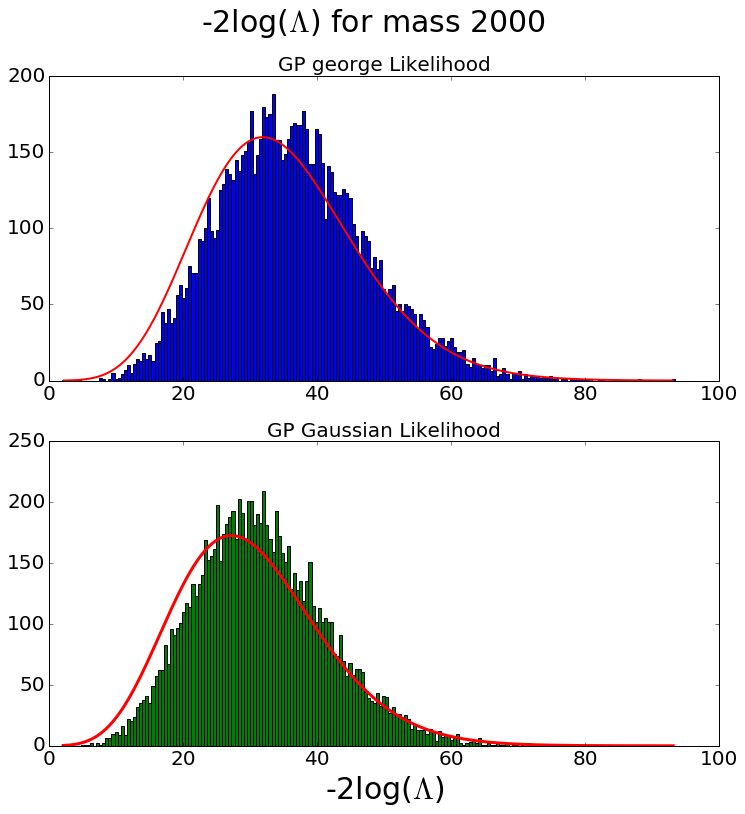

nc  [ 30.62197891]
nc  [ 30.62197891]


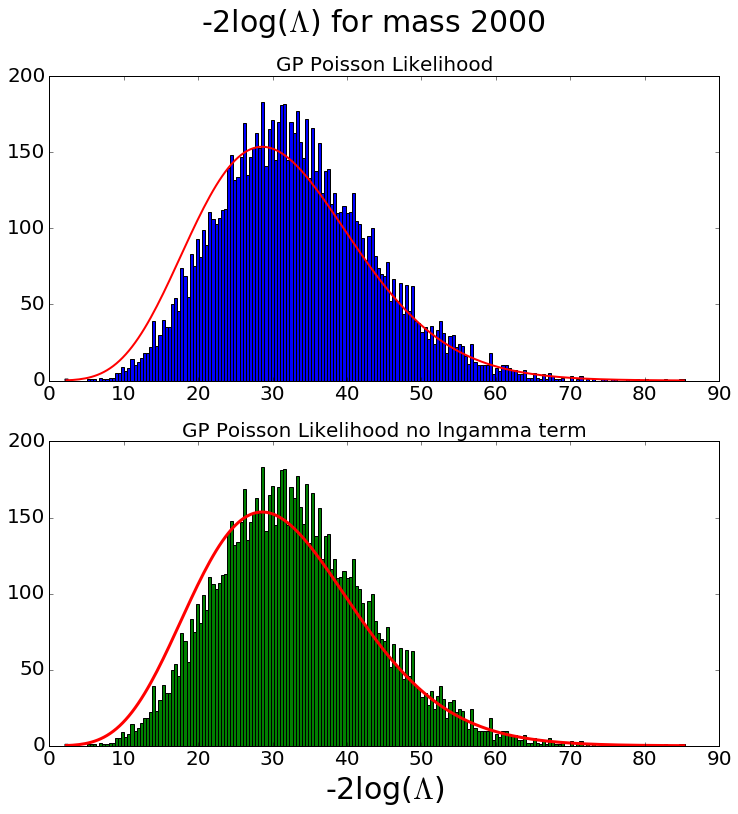

george, gaussian, poisson, poisson with no lngamma % < 0:  0.0 , 5.28 , 0.25 , 0.25
nc  [ 4.72822392]
nc  [ 8.40837213]


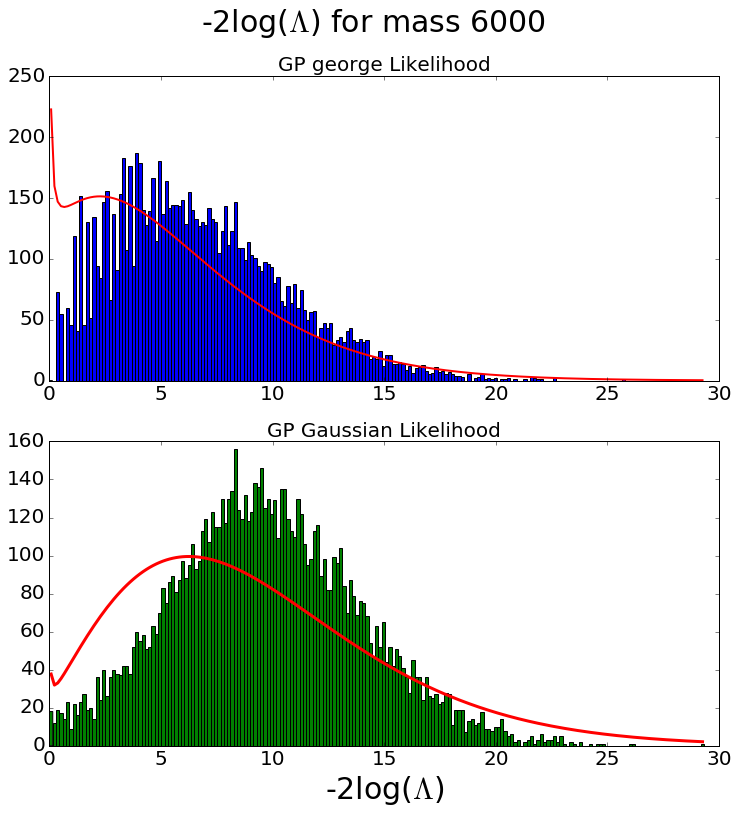

nc  [ 30.26089145]
nc  [ 30.26089145]


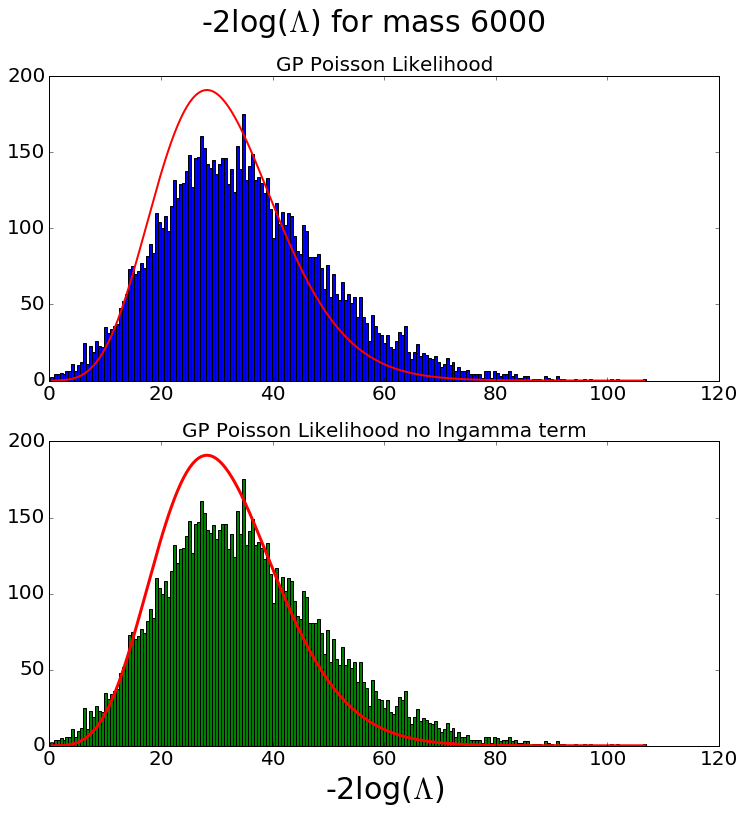

In [215]:
standardParamSets = [(1500,2000,250), (15, 6000,250)]
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
GPlist=[]
GPlistP=[]
GPlistG=[]
GPlistng=[]
for m in msignals:

    gp = [s for s in LLlistGP[m] if not (np.isinf(s) or np.isnan(s))]
    G = [s for s in LLlistGPG[m] if not (np.isinf(s) or np.isnan(s))]
    ng = [s for s in LLlistGPng[m] if not (np.isinf(s) or np.isnan(s))]
    P = [s for s in LLlistGPP[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac = round(100.*sum(i < 0 for i in gp)/len(gp),2)
    gpG_neg_frac = round(100.*sum(i < 0 for i in G)/len(G),2)
    gpng_neg_frac = round(100.*sum(i < 0 for i in ng)/len(ng), 2)
    gpP_neg_frac = round(100.*sum(i < 0 for i in P)/len(P),2)
    
    print "george, gaussian, poisson, poisson with no lngamma % < 0: ", gp_neg_frac, ",", gpG_neg_frac,",", gpP_neg_frac, ",",gpng_neg_frac
    
    GPlist.append([np.median(np.array(gp)), np.std(np.array(gp))/np.sqrt(len(gp))])
    GPlistP.append([np.median(np.array(P)), np.std(np.array(P))/np.sqrt(len(P))])

    gp = [s for s in gp if s > 0]
    G = [s for s in G if s > 0]
    ng = [s for s in ng if s > 0]
    P = [s for s in P if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(gp, G, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="GP george Likelihood", label2 = "GP Gaussian Likelihood")
    makePrettyPlots_LLH(P, ng, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="GP Poisson Likelihood", label2 = "GP Poisson Likelihood no lngamma term")

### Distribution of log likelihood ratio for 3 parameter fit function, with non central chi2 overlaid

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.0 , 0.24 , 0.9
nc  [ 17.15541163]
nc  [ 18.03779029]


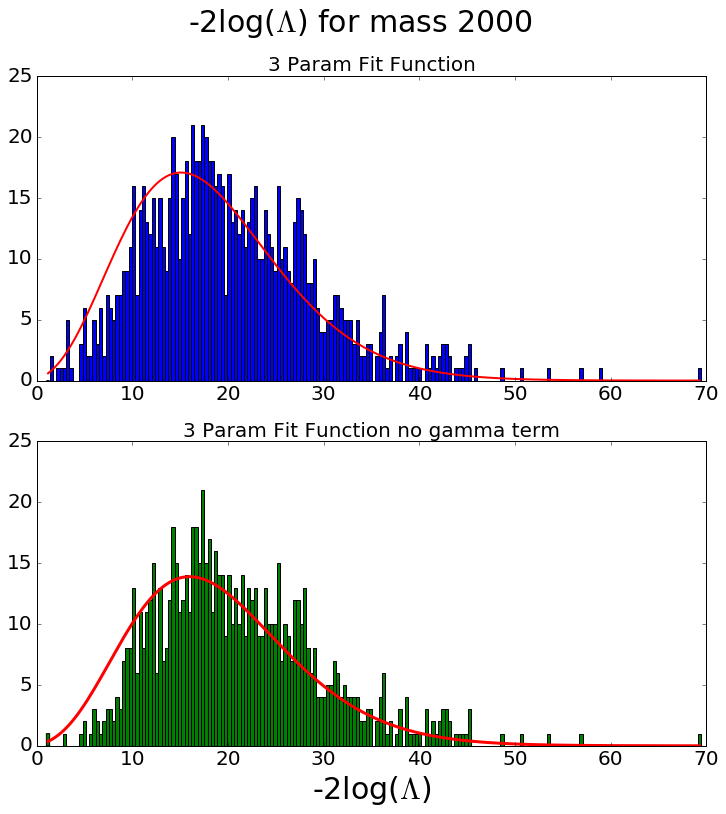

nc  [ 17.15624913]
nc  [ 19.53493716]


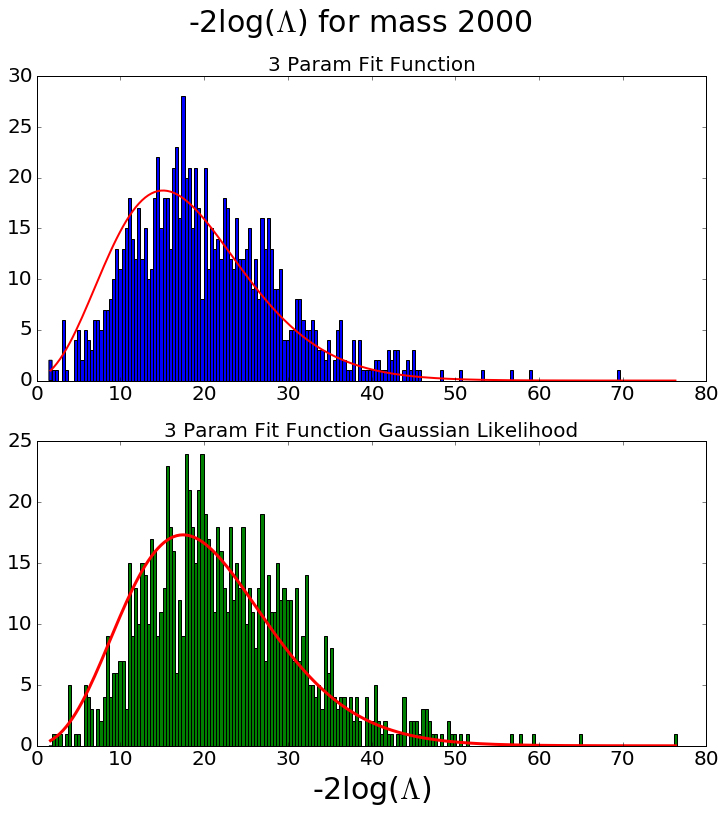

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.2 , 0.0 , 3.1
nc  [ 30.09855398]
nc  [ 29.95279454]


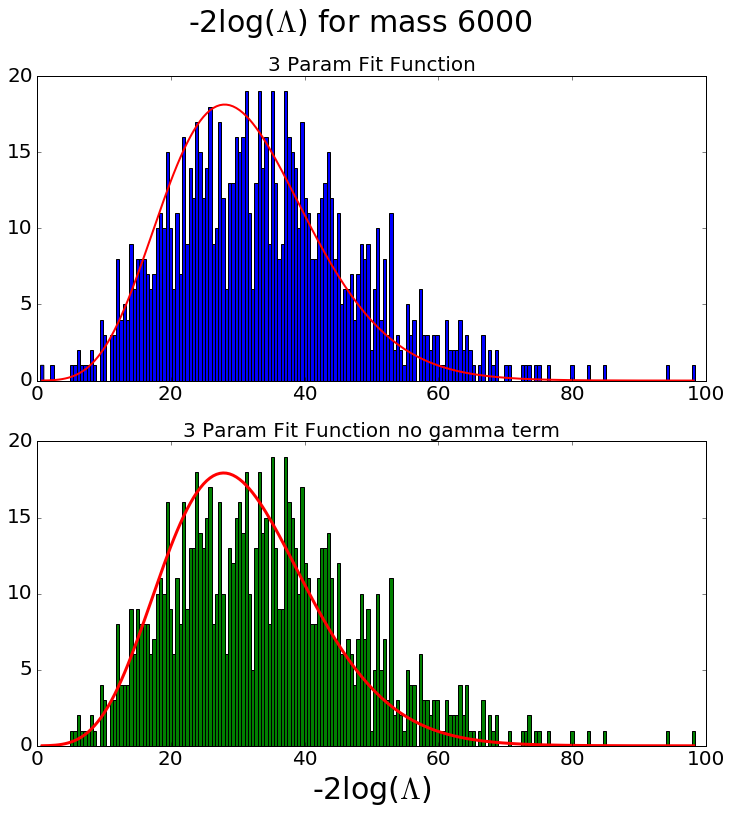

nc  [ 30.09839505]
nc  [ 10.51773134]


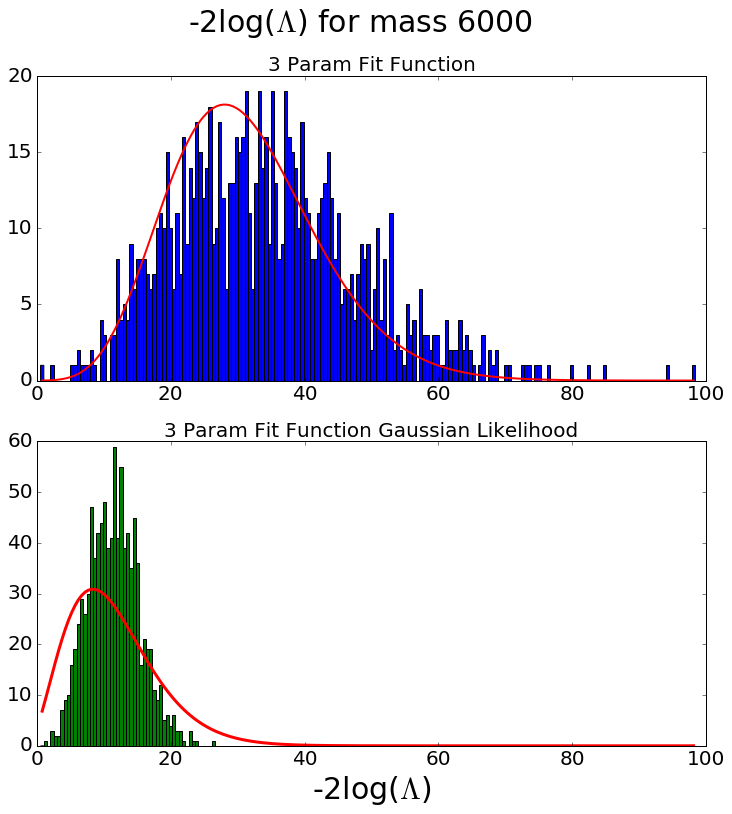

In [216]:
standardParamSets = [(1500,2000,250), (15, 6000,250)]
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

FFlist3=[]
FFlist3G=[]
FFlist3ng=[]
for m in msignals:


    ff = [s for s in LLlistFF[m] if not (np.isinf(s) or np.isnan(s))]
    G = [s for s in LLlistFFG[m] if not (np.isinf(s) or np.isnan(s))]
    ng = [s for s in LLlistFFng[m] if not (np.isinf(s) or np.isnan(s))]
    
    ff_neg_frac = round(100.*sum(i < 0 for i in ff)/len(ff),2)
    ffG_neg_frac = round(100.*sum(i < 0 for i in G)/len(G),2)
    ffng_neg_frac = round(100.*sum(i < 0 for i in ng)/len(ng),2)
    
    print "3 parameter poisson, poisson with no lngamma, gaussian % < 0: ", ff_neg_frac, "," , ffng_neg_frac, "," , ffG_neg_frac
    
    FFlist3.append([np.median(np.array(ff)), np.std(np.array(ff))/np.sqrt(len(ff))])
    FFlist3ng.append([np.median(np.array(ng)), np.std(np.array(ng))/np.sqrt(len(ng))])
    FFlist3G.append([np.median(np.array(G)), np.std(np.array(G))/np.sqrt(len(G))])
    
    ff = [s for s in ff if s > 0]
    G = [s for s in G if s > 0]
    ng = [s for s in ng if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(ff, ng, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function", label2 = "3 Param Fit Function no gamma term" )
    makePrettyPlots_LLH(ff, G, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function", label2 = "3 Param Fit Function Gaussian Likelihood" )



In [275]:
def plotBestFitParams(paramList, paramNames, title):
    f, ax = plt.subplots(1, len(paramList[0]), figsize=(15,5))
    f.suptitle(title, fontsize=20, y = 1.08)
    paramList = [s for s in paramList if not all([True if b == 0 else False for b in s])]
    for iparam in range(len(paramList[0])):
        ax[iparam].set_xlabel(paramNames[iparam], fontsize=15)
        p = [paramList[i][iparam] for i in range(len(paramList))]
        ax[iparam].hist(p, bins=np.linspace(min(p), max(p), 50))
        ax[iparam].axvline(np.mean(p), color='r', linestyle='dashed', linewidth=2)
        ax[iparam].annotate(str(round(np.mean(p),3)), xy=(0.75, 0.75), xycoords='axes fraction')

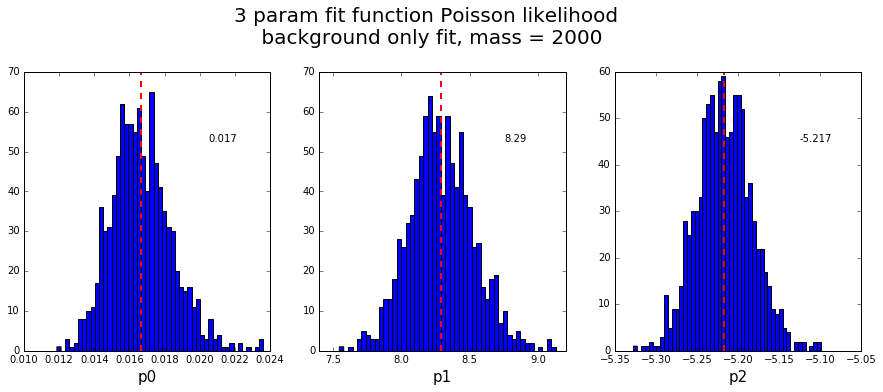

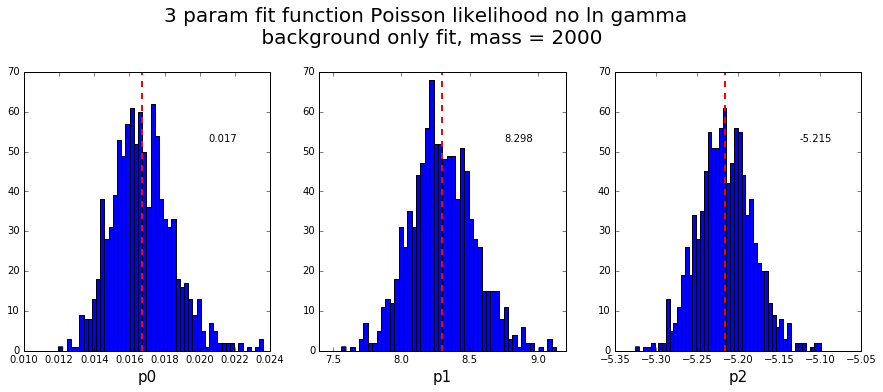

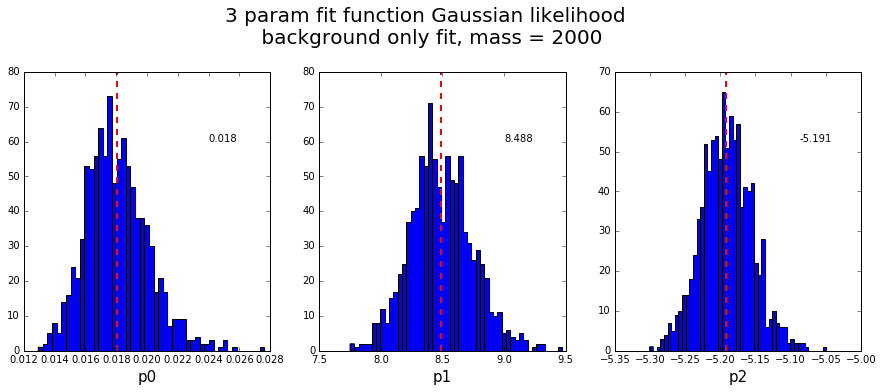

In [276]:
msignals = [2000]
for m in msignals:
    plotBestFitParams(paramlistFF_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFFng_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFFG_b[m], ['p0','p1','p2'], "3 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

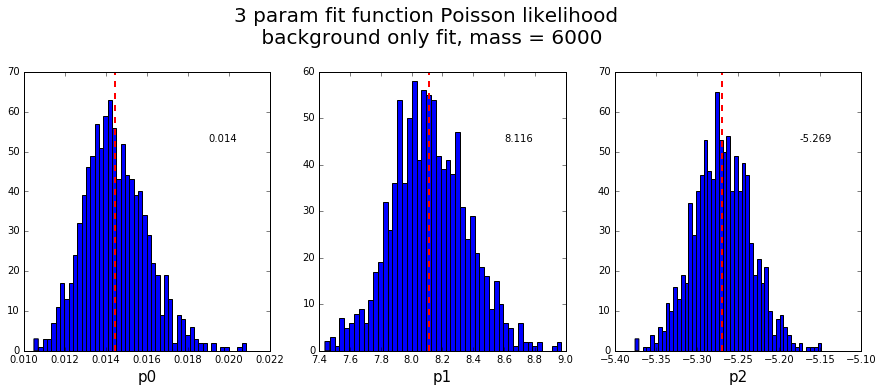

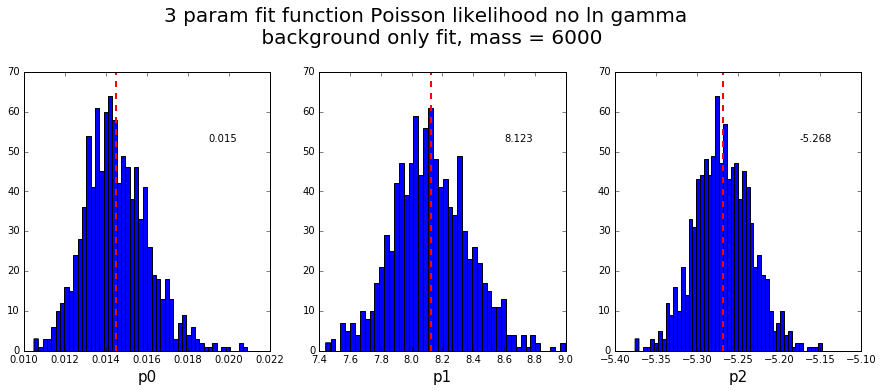

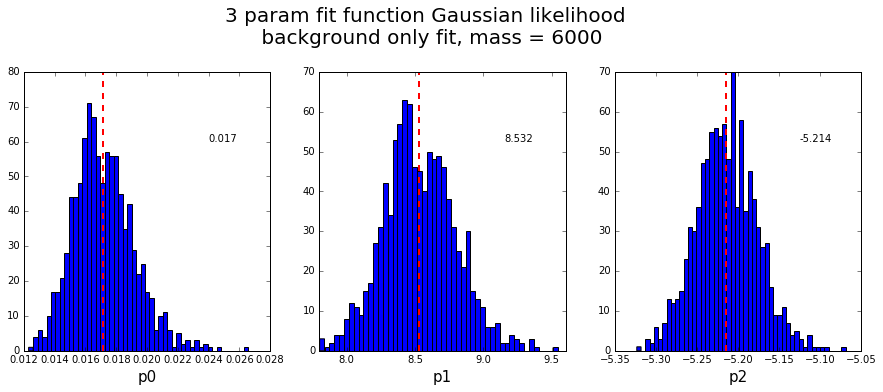

In [277]:
msignals = [6000]

for m in msignals:
    plotBestFitParams(paramlistFF_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFFng_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFFG_b[m], ['p0','p1','p2'], "3 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

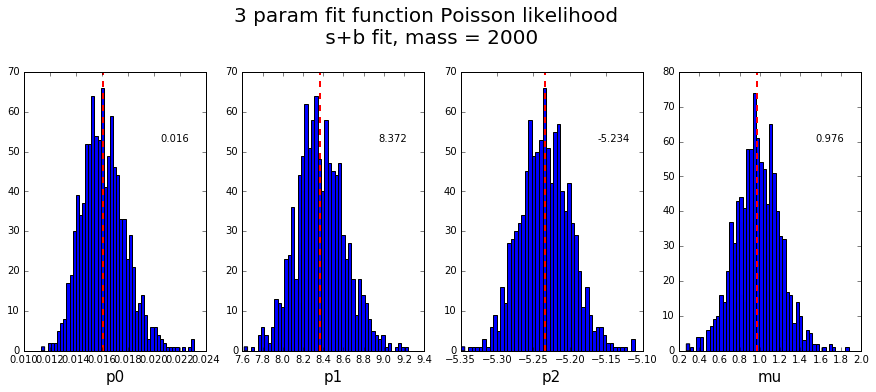

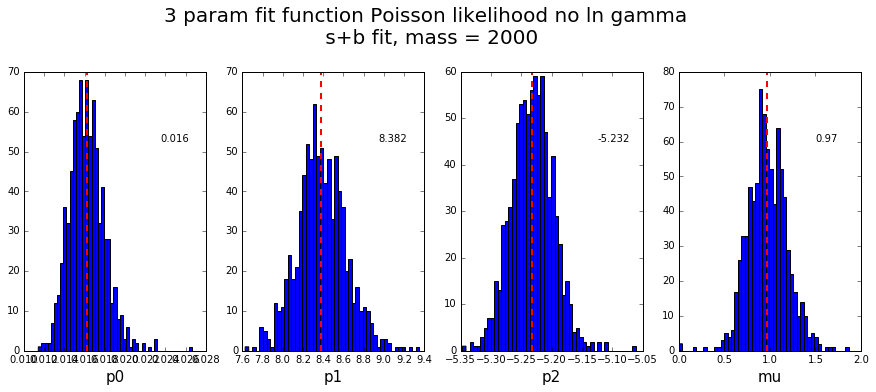

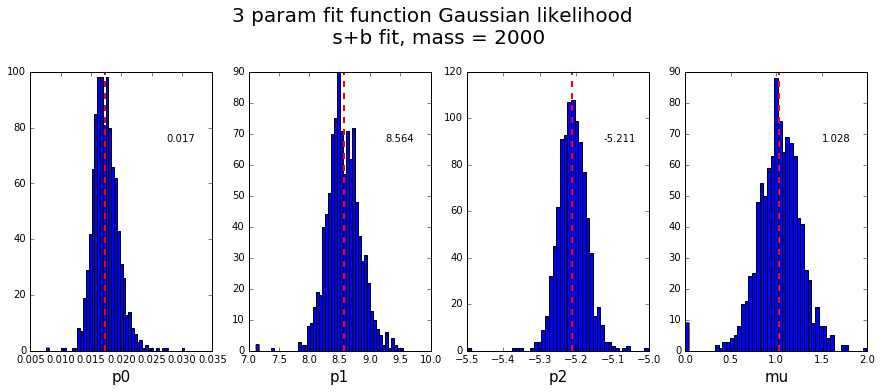

In [278]:
msignals = [2000]
for m in msignals:
    plotBestFitParams(paramlistFF_sb[m], ['p0','p1','p2', 'mu'], "3 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFFng_sb[m], ['p0','p1','p2', 'mu'], "3 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFFG_sb[m], ['p0','p1','p2','mu'], "3 param fit function Gaussian likelihood \n s+b fit, mass = "+ str(m))

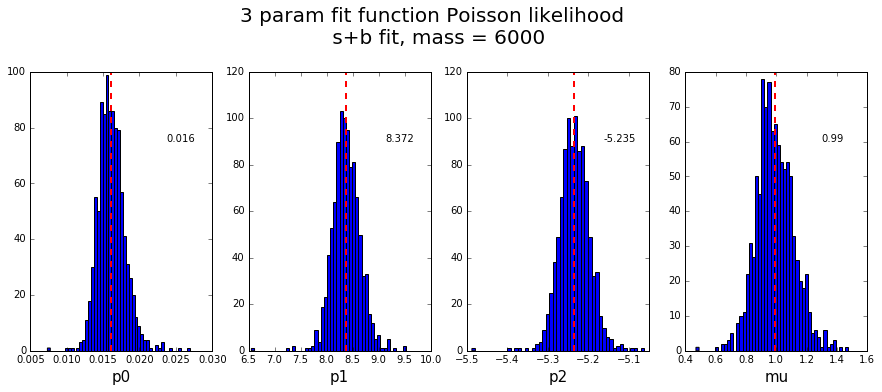

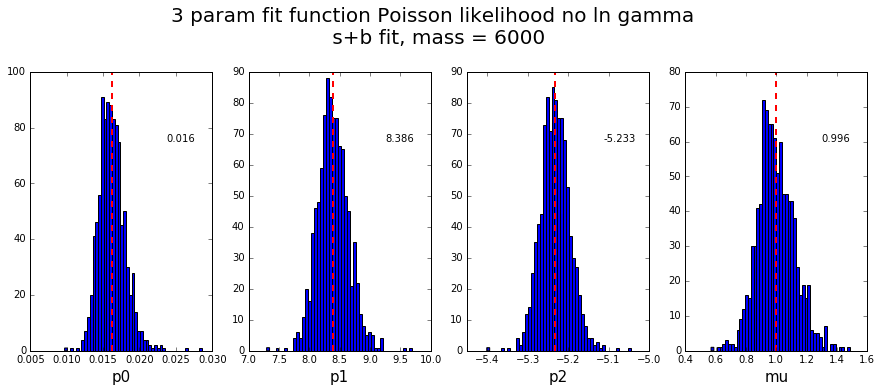

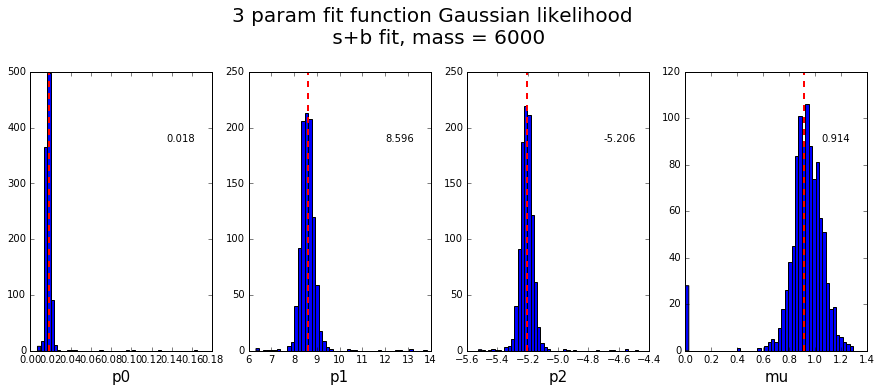

In [279]:
msignals = [6000]
for m in msignals:
    plotBestFitParams(paramlistFF_sb[m], ['p0','p1','p2', 'mu'], "3 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFFng_sb[m], ['p0','p1','p2', 'mu'], "3 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFFG_sb[m], ['p0','p1','p2','mu'], "3 param fit function Gaussian likelihood \n s+b fit, mass = "+ str(m))

### average LLH ratio for each injected signal

In [217]:
standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

FFlist3b=[]
GPlistb=[]
GPlistPb=[]
for m in msignals:

    ff = np.load("savedOutputs/LLHR_3param_"+str(m)+"_withSignal.npy")
    gp = np.load("savedOutputs/LLHR_GP_"+str(m)+"_withSignal.npy")
    gpp = np.load("savedOutputs/LLHR_GP_other_"+str(m)+"_withSignal.npy")


    FFlist3b.append([np.median(np.array(ff)), np.std(np.array(ff))/np.sqrt(len(ff))])
    GPlistb.append([np.median(np.array(gp)), np.std(np.array(gp))/np.sqrt(len(gp))])
    GPlistPb.append([np.median(np.array(gpp)), np.std(np.array(gpp))/np.sqrt(len(gpp))])


(1, 1100)

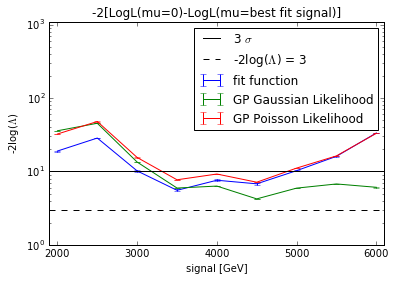

In [218]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
plt.figure()
plt.errorbar(msignals, [FFlist3b[i][0] for i in range(len(msignals))], yerr = [FFlist3b[i][1] for i in range(len(msignals))], color="b", label="fit function")
plt.errorbar(msignals, [GPlistb[i][0] for i in range(len(msignals))], yerr = [GPlistb[i][1] for i in range(len(msignals))], color="g", label="GP Gaussian Likelihood")
plt.errorbar(msignals, [GPlistPb[i][0] for i in range(len(msignals))], yerr = [GPlistPb[i][1] for i in range(len(msignals))], color="r", label="GP Poisson Likelihood")
plt.plot([1900,6100], 10*np.ones(2), c='black', label=r'3 $\sigma$')
plt.plot([1900,6100], 3*np.ones(2), c='black', ls='--', label=r"-2log($\Lambda$) = 3")

plt.xlabel("signal [GeV]")
plt.yscale('log', nonposy="clip")
plt.xlim([1900, 6100])
plt.title("-2[LogL(mu=0)-LogL(mu=best fit signal)]")
plt.ylabel(r"-2log($\Lambda$)")
plt.legend(loc=1)
plt.ylim([1, 1100])